In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import seaborn  as sns
import statsmodels.api as sm 

from pandas.core.frame import DataFrame
from glassnode import *
from tqdm import tqdm
from utilities import ohlc_plot


plt.rcParams['figure.figsize'] = [15, 7]
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
sns.set()

In [2]:
df = pd.read_csv('selectedTable.csv')
df.index = pd.to_datetime(df['t'])
del df['t']

df = df.astype('float32')

In [3]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

def Regression(df,
               trainPeriodStart,
               trainPeriodEnd,
               cvPeriodStart,
               list_of_features = ['market_deltacap_usd']):
    
    
    endo = np.log(df['px_close']).diff().dropna()
    exog = df[list_of_features].loc[endo.index]
    

    if isinstance(exog,pd.Series):
        pval = adfuller(exog)[1]
        if pval > 0.1:
            Exog = exog.diff().loc[endo.index]
        else:
            Exog = exog.loc[endo.index].copy()
            
    elif isinstance(exog,pd.DataFrame):
        Exog = []
        for c in exog.columns:
            
            pval = adfuller(exog[c])[1]
            
            if pval>0.1:
                Exog.append(np.log(exog[c]).diff().loc[endo.index])
            else:
                Exog.append(exog[c].loc[endo.index].copy())
        
        Exog = pd.concat(Exog,axis = 1)
        
    dta = pd.concat([endo,Exog],axis = 1).dropna()
    
    Xtrain = dta.loc[trainPeriodStart:trainPeriodEnd,dta.columns != 'px_close'].values
    ytrain = dta.loc[trainPeriodStart:trainPeriodEnd,'px_close'].values
    train_idx = dta.loc[trainPeriodStart:trainPeriodEnd,'px_close'].index

    Xcv = dta.loc[cvPeriodStart:,dta.columns != 'px_close'].values
    ycv = dta.loc[cvPeriodStart:,'px_close'].values
    cv_idx = dta.loc[cvPeriodStart:,'px_close'].index
    
    Xshape = Xtrain.shape
    
    if len(Xshape) == 1:
        
        reg = LinearRegression().fit(Xtrain.reshape(-1,1), ytrain)
        predicted = reg.predict(Xcv.reshape(-1,1))
        fittedval = reg.predict(Xtrain.reshape(-1,1))
    else:
        reg = LinearRegression().fit(Xtrain, ytrain)
        predicted = reg.predict(Xcv)
        fittedval = reg.predict(Xtrain)
    
    fittd = pd.Series(fittedval,index = train_idx)
    pred = pd.Series(predicted,index = cv_idx)
    out = pd.concat([fittd,pred],axis = 0)
    return out.rename('Implied_BTC')

In [20]:
def plot_results(out,px,trainPeriodStart,trainPeriodEnd,cvPeriodStart):
    csum = out.cumsum()
    csum_out_train = csum.loc[trainPeriodStart:trainPeriodEnd]
    csum_out_cv = csum.loc[cvPeriodStart:]
    
    cr = np.log(px).diff().fillna(0).cumsum()
    
    
    f,a = plt.subplots(nrows=1,sharex=True);
    csum_out_train.plot(ax=a,style = '-');
    csum_out_cv.plot(ax = a,style = 'g--');
    cr.plot(ax = a,style = 'k-');
    return f

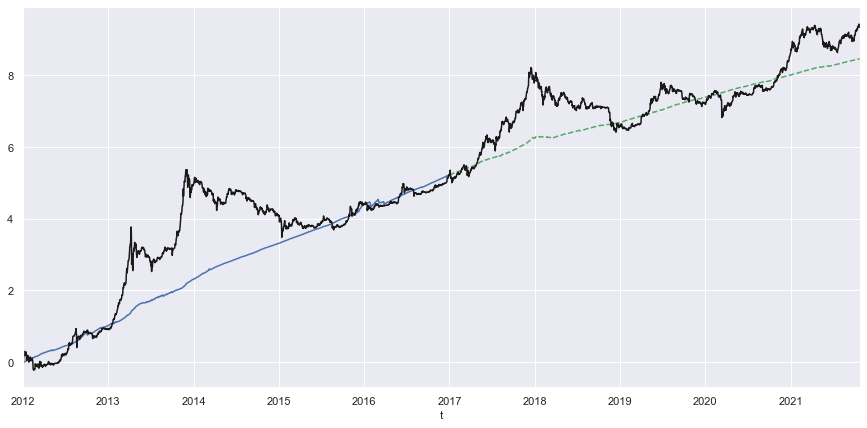

In [21]:
list_of_features = df.columns[4:6]
trainPeriodStart = '2012-01-01'
trainPeriodEnd = '2016-12-31'
cvPeriodStart = '2017-01-01'

out = Regression(df,'2012-01-01','2016-12-31','2017-01-01',list_of_features)
f = plot_results(out,df['px_close'],trainPeriodStart,trainPeriodEnd,cvPeriodStart)

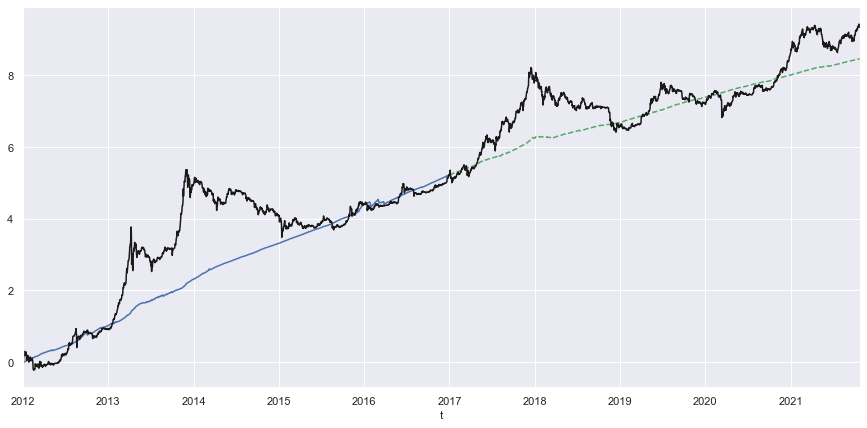

In [18]:
f